# k-means clustering


## Data re-processing

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

In [4]:
datamart = pd.read_csv('datamart_rfm.csv')
datamart.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12747,3,25,948.70
1,12748,1,888,7046.16
2,12749,4,37,813.45
3,12820,4,17,268.02
4,12822,71,9,146.15


In [6]:
scaler = StandardScaler()
scaler.fit(datamart)

datamart_normalized = scaler.transform(datamart)

In [7]:
print('mean: ',datamart_normalized.mean(axis=0).round(2))
print('std: ',datamart_normalized.std(axis=0).round(2))

mean:  [-0. -0. -0.  0.]
std:  [1. 1. 1. 1.]


In [40]:
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart.index, columns=datamart.columns)
datamart_normalized

,CustomerID,Recency,Frequency,MonetaryValue
0,-1.795103,-0.925896,0.143679,0.429024
1,-1.794463,-0.947075,19.870087,4.954851
2,-1.793822,-0.915306,0.417975,0.328634
3,-1.748379,-0.915306,-0.039184,-0.076210
4,-1.747099,-0.205813,-0.222048,-0.166668
...,...,...,...,...
3638,1.746304,1.986205,-0.382053,-0.246422
3639,1.746944,0.959028,-0.382053,-0.251544
3640,1.747584,-0.872949,-0.382053,-0.252360
3641,1.748224,-0.915306,3.046639,0.046194


## Build Model

Ao executar k-means, você terá que passar o número de clusters. Esta decisão não é fácil, se não houver dados que justifiquem a escolha. Felizmente, existem vários métodos para obter uma boa estimativa do que deveria ser: 

    Usaremos métodos visuais, como o critério do cotovelo, são fáceis de interpretar e fornecem uma boa estimativa. 

Existem também métodos matemáticos, como o coeficiente de silhueta, que é útil ao tentar encontrar um modelo com clusters mais bem definidos. Não sem suas advertências, mas ainda comumente usado. Não usaremos este método para nosso projeto de segmentação. 

Por fim, é importante entender que esses métodos devem ser interpretados como consultivos, pois estamos segmentando clientes. A interpretação de cada solução deve primeiro fazer sentido para a empresa e ser acionável.

In [11]:
from sklearn.cluster import KMeans

In [64]:
kmeans = KMeans(n_clusters = 3, random_state = 1)

In [65]:
kmeans.fit(datamart_normalized)

KMeans(n_clusters=3, random_state=1)

In [66]:
cluster_labels = kmeans.labels_

## Analysing Clusters

In [67]:
datamart_kn = datamart.assign(Cluster=cluster_labels)

In [68]:
datamart_kn.groupby(['Cluster']).agg({'Recency':'mean',
                                     'Frequency':'mean',
                                     'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          22.8     380.8       15403.0    15
1          43.3      20.9         373.6  2750
2         239.2       5.8         104.9   878

### Profile and interpret segments


In [69]:
datamart_normalized['Cluster'] = datamart_kn['Cluster']

datamart_melt = pd.melt(datamart_normalized.reset_index(),
                       id_vars=['CustomerID','Cluster'],
                       value_vars=['Recency','Frequency','MonetaryValue'],
                       var_name='Attribute',
                       value_name='Value')
datamart_melt

,CustomerID,Cluster,Attribute,Value
0,-1.795103,1,Recency,-0.925896
1,-1.794463,0,Recency,-0.947075
2,-1.793822,1,Recency,-0.915306
3,-1.748379,1,Recency,-0.915306
4,-1.747099,1,Recency,-0.205813
...,...,...,...,...
10924,1.746304,2,MonetaryValue,-0.246422
10925,1.746944,2,MonetaryValue,-0.251544
10926,1.747584,1,MonetaryValue,-0.252360
10927,1.748224,1,MonetaryValue,0.046194


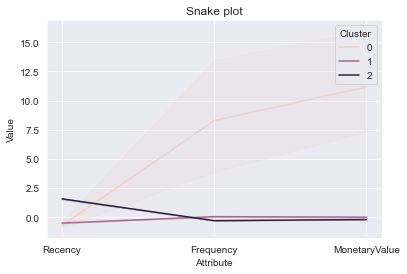

In [70]:
plt.title('Snake plot')
sns.lineplot(x="Attribute",y="Value",hue="Cluster",data=datamart_melt)
plt.show()

In [74]:
cluster_avg = datamart_kn.groupby(['Cluster']).mean()
population_avg = datamart.mean()
relative_imp = cluster_avg/population_avg - 1

In [75]:
relative_imp.round(2)

,CustomerID,Recency,Frequency,MonetaryValue
Cluster,,,,
0,-0.01,-0.75,19.35,40.55
1,-0.00,-0.52,0.11,0.01
2,0.00,1.64,-0.69,-0.72


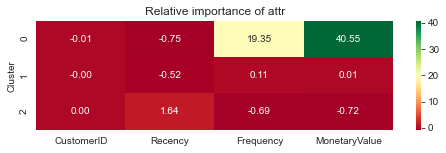

In [77]:
plt.figure(figsize=(8,2))
plt.title("Relative importance of attr")
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap='RdYlGn')
plt.show()

## Choosing the number of clusters


Vamos nos concentrar no critério do cotovelo e na experimentação.

O método de critério de cotovelo plota a soma dos erros quadrados (SSE) para cada número de segmentos. A soma dos erros quadrados é basicamente a soma das distâncias quadradas de cada ponto de dados até o centro do cluster. Em seguida, examinamos o gráfico para identificar onde a redução no SSE desacelera e se torna um tanto marginal. 

Esse ponto se parece com o cotovelo de um braço dobrado e mostra onde há retornos decrescentes ao aumentar o número de clusters. Este ponto representa o número ideal de clusters de uma perspectiva de erros de soma dos quadrados. No entanto, devemos escolher várias opções ao redor do cotovelo para testar o que faz mais sentido.

In [25]:
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ #soma

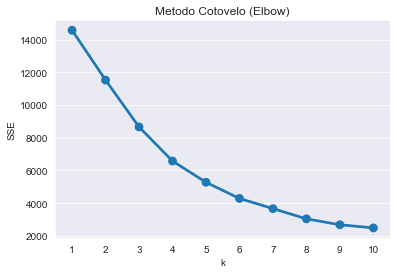

In [29]:
plt.title('Metodo Cotovelo (Elbow)')

sns.pointplot(x=list(sse.keys()),y=list(sse.values()))

plt.xlabel('k')
plt.ylabel('SSE')

plt.show()



## End to End

In [80]:
datamart_rfmt = pd.read_csv('datamart_rfmt.csv')

In [81]:
datamart_rfmt_log = np.log(datamart_rfmt)

scaler = StandardScaler(); scaler.fit(datamart_rfmt_log)

datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

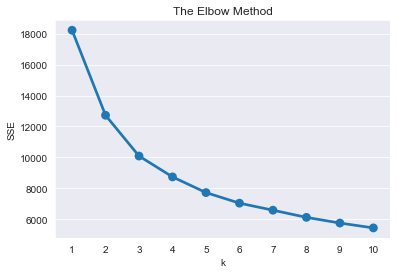

In [82]:
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    sse[k] = kmeans.inertia_   

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 1) 
kmeans.fit(datamart_rfmt_normalized)
cluster_labels = kmeans.labels_

In [83]:
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster=cluster_labels)

grouped = datamart_rfmt_k4.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          22.8     380.8       15403.0  327.2    15
1          43.3      20.9         373.6  188.4  2750
2         239.2       5.8         104.9  261.4   878

In [84]:
cluster_avg = datamart_rfmt_k4.groupby(['Cluster']).mean()
population_avg = datamart.mean()
relative_imp = cluster_avg/population_avg - 1

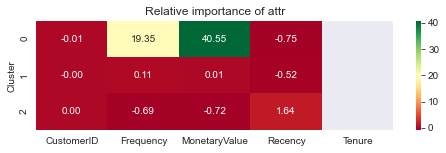

In [85]:
plt.figure(figsize=(8,2))
plt.title("Relative importance of attr")
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap='RdYlGn')
plt.show()